# **Desenvolvimento de Modelo Preditivo**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

import pycaret
import pycaret.classification as pcc
from pycaret.utils import check_metric

from sklearn.model_selection import train_test_split

In [17]:
from imblearn.over_sampling import SMOTE, ADASYN 
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [13]:
df = pd.read_csv(filepath_or_buffer='ml_project1_data_NOVO.csv', index_col=0)

keys = ['ID']
target = ['Response']

features = [ col for col in list(df) if col not in keys+target ]

num_features = list(df[features]._get_numeric_data())

cat_features = [ col for col in features if col not in num_features ]

num_features.remove('Year_Birth')

cat_features.remove('Dt_Customer')

features = num_features+cat_features

In [15]:
df_train, df_test = train_test_split(df, test_size=0.25, stratify=df[target], random_state=42)

In [18]:
ada = ADASYN(sampling_strategy='all', random_state = 42)

In [20]:
#Parametrização PyCaret

topAlgs = 5              # top n algoritmos para modelagem
train_size = 0.75         # tamanho da base de treino 
compareFolds = 3         # quantidade de folds para treino
compareMetric = 'auc'    # metrica para avaliação dos modelos (topAlgs) e para otimização
tuneIters = 15           # numero de iterações na etapa de tunning

In [62]:
modelo_clf = pcc.setup(data = df_train[keys+features+target], 
                         target = 'Response', 
                         train_size = train_size,
                         ignore_features = keys,
                         categorical_features = cat_features,
                         fix_imbalance = True,
                         fix_imbalance_method = None,
                         fold_shuffle=True,
                         feature_selection_method = 'boruta',
                         silent = True,
                         imputation_type = 'iterative',                             
                         normalize = True,
                         session_id = 42)

In [63]:
top_algs = pcc.compare_models(n_select = topAlgs, fold = compareFolds, sort = compareMetric)

In [64]:
melhor_alg = pcc.tune_model(top_algs[0], fold = 5, optimize = 'auc', n_iter = 50)

In [78]:
df_train_score = pcc.predict_model(melhor_alg, data=df_train, raw_score=True)
df_test_score = pcc.predict_model(melhor_alg, data=df_test, raw_score=True)

df_train_score['Score'] = df_train_score['Score_1']
df_test_score['Score'] = df_test_score['Score_1']

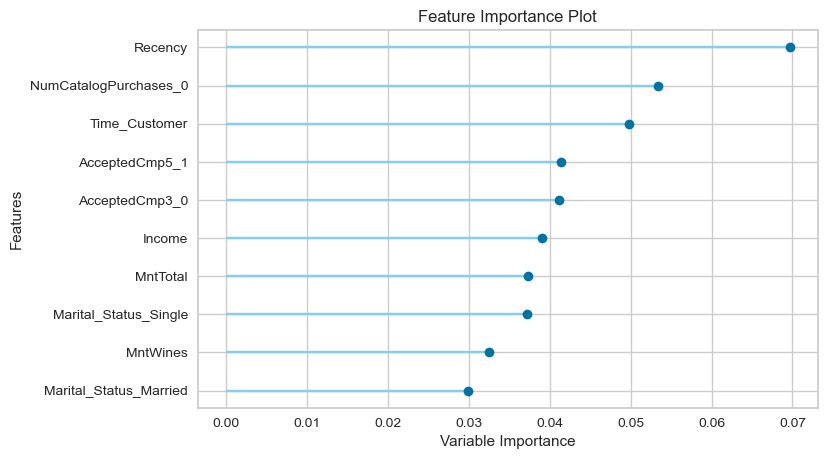

In [88]:
#Importância das Features

pcc.plot_model(melhor_alg, plot = 'feature')

In [80]:
print('Desempenhos de Treino e Teste')

auc_train = roc_auc_score(y_true=df_train_score[target], y_score=df_train_score['Score_1'])
auc_test = roc_auc_score(y_true=df_test_score[target], y_score=df_test_score['Score_1'])

print('AUC Treino: %.2f'%(100*auc_train))
print('AUC Teste: %.2f'%(100*auc_test))

Desempenhos de Treino e Teste
AUC Treino: 97.43
AUC Teste: 89.03


In [81]:
df_test_score['decil_scores'] = pd.qcut(df_test_score['Score'], q=10)

In [85]:
df_test_score['decil_scores'].value_counts().reset_index()

index  decil_scores
0                  (0.00569, 0.0112]            57
1  (-0.0007000000000000001, 0.00569]            56
2                   (0.0189, 0.0306]            56
3                     (0.0306, 0.05]            56
4                     (0.05, 0.0928]            56
5                    (0.0928, 0.145]            56
6                     (0.145, 0.261]            56
7                     (0.261, 0.602]            56
8                     (0.602, 0.991]            56
9                   (0.0112, 0.0189]            55

In [83]:
df_test_score.groupby(by='decil_scores')['Response'].mean().reset_index()

decil_scores  Response
0  (-0.0007000000000000001, 0.00569]  0.000000
1                  (0.00569, 0.0112]  0.000000
2                   (0.0112, 0.0189]  0.036364
3                   (0.0189, 0.0306]  0.017857
4                     (0.0306, 0.05]  0.017857
5                     (0.05, 0.0928]  0.071429
6                    (0.0928, 0.145]  0.142857
7                     (0.145, 0.261]  0.142857
8                     (0.261, 0.602]  0.375000
9                     (0.602, 0.991]  0.678571

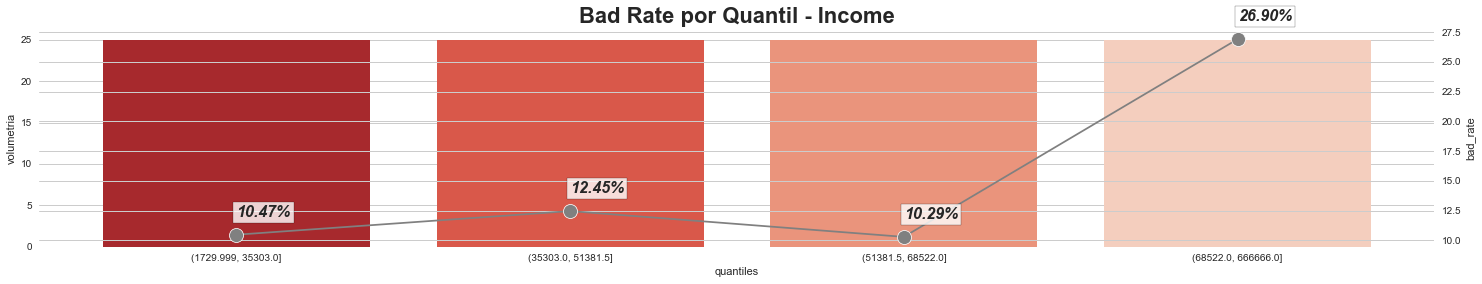

In [91]:
df['Income_quantiles'] = pd.qcut(df['Income'], q=4)

df_bad_rate_quantiles = pd.DataFrame(columns=['volumetria', 'bad_rate'])

df_bad_rate_quantiles['volumetria'] = 100*df['Income_quantiles'].value_counts(normalize=True)
df_bad_rate_quantiles['bad_rate'] = 100*df.groupby(by='Income_quantiles')['Response'].mean()

df_bad_rate_quantiles.sort_index(inplace=True)

df_bad_rate_quantiles.reset_index(level=0, inplace=True)
df_bad_rate_quantiles.rename(columns={'index': 'quantiles'}, inplace=True)
df_bad_rate_quantiles['quantiles'] = df_bad_rate_quantiles['quantiles'].astype('str')

#graficos 
plt.figure(figsize=(25,4))

sns.barplot(data=df_bad_rate_quantiles, x='quantiles', y='volumetria', palette = 'Reds_r', )
ax2 = plt.twinx()
sns.lineplot(data=df_bad_rate_quantiles, x='quantiles', y='bad_rate', ax=ax2, marker='o', color='gray', markersize=14)

plt.title('Bad Rate por Quantil - Income', fontsize=22, weight='bold')

x = df_bad_rate_quantiles.index
n = df_bad_rate_quantiles['bad_rate']

for i, v in enumerate(n):
    plt.text(x[i], n[i]+1.5, "%.2f%%"%(v), fontsize=16, weight='bold', style='italic', bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 3})

sns.despine(bottom = True, left = True)
plt.show()